# Data preprocessing

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 
import seaborn as sns
from pandas.api.types import union_categoricals

### Read dataset

In [10]:
data = pd.read_csv('../data/processed_data/processed_data_2015_onward_mean.csv')

In [11]:
data.head(20)

,EventDate,Actor1CountryCode,Actor2CountryCode,GoldsteinScale_Averaged,AvgTone_Averaged,NumMentions_averaged,NumArticles_averaged
0,2015-01-31,AFG,PAK,1.062500,0.275670,4.125000,4.125000
1,2015-01-31,AFG,USA,1.693333,-1.697247,7.933333,7.933333
2,2015-01-31,AFR,BDI,-1.000000,0.353357,5.000000,5.000000
3,2015-01-31,AFR,USA,2.800000,5.889282,10.000000,10.000000
4,2015-01-31,AFR,ZAF,-10.000000,-5.931919,4.000000,4.000000
5,2015-01-31,ARM,BGR,3.400000,2.430847,5.000000,5.000000
6,2015-01-31,AUS,ARE,-10.000000,-5.566219,3.000000,3.000000
7,2015-01-31,AUS,USA,1.000000,4.019882,5.500000,5.500000
8,2015-01-31,BFA,CIV,3.400000,-4.093567,6.000000,6.000000
9,2015-01-31,BHR,ARE,-10.000000,-13.043478,6.000000,6.000000


### Alphabetical order transformation

### Remove tuples that contain the same two countries but in different order by averaging the values from both tuples (ex. AFG - PAK and PAK - AFG)

In [158]:
data[['Actor1CountryCode', 'Actor2CountryCode']] = \
    data[['Actor1CountryCode', 'Actor2CountryCode']].apply(
        lambda x: sorted(x), axis=1, result_type='expand'
    )

In [159]:
data = data.groupby(['EventDate', 'Actor1CountryCode',	'Actor2CountryCode'])[['GoldsteinScale_Summed',	'AvgTone_Summed', 'NumMentions_averaged', 'NumArticles_averaged']].mean().reset_index()

In [160]:
data.head(5)

,EventDate,Actor1CountryCode,Actor2CountryCode,GoldsteinScale_Summed,AvgTone_Summed,NumMentions_averaged,NumArticles_averaged
0,2015-01-31,AFG,PAK,19.8,-7.682500,4.270833,4.270833
1,2015-01-31,AFG,USA,54.2,-37.340634,6.758333,6.758333
2,2015-01-31,AFR,BDI,-2.0,0.706714,5.000000,5.000000
3,2015-01-31,AFR,DJI,5.2,-1.477833,3.000000,3.000000
4,2015-01-31,AFR,NGA,1.0,-2.072539,6.000000,6.000000


### Familiarization

In [161]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239911 entries, 0 to 239910
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   EventDate              239911 non-null  object 
 1   Actor1CountryCode      239911 non-null  object 
 2   Actor2CountryCode      239911 non-null  object 
 3   GoldsteinScale_Summed  239911 non-null  float64
 4   AvgTone_Summed         239911 non-null  float64
 5   NumMentions_averaged   239911 non-null  float64
 6   NumArticles_averaged   239911 non-null  float64
dtypes: float64(4), object(3)
memory usage: 12.8+ MB


In [162]:
data.describe()

,GoldsteinScale_Summed,AvgTone_Summed,NumMentions_averaged,NumArticles_averaged
count,239911.000000,239911.000000,239911.000000,239911.000000
mean,9.275700,-18.276952,5.150839,5.048537
std,97.098742,178.496344,3.026468,2.871697
min,-25274.300000,-43551.428705,1.000000,1.000000
25%,0.000000,-11.111111,3.125000,3.050000
50%,3.500000,-2.623038,5.000000,4.872727
75%,10.600000,2.719033,6.000000,6.000000
max,3808.500000,396.169518,275.000000,275.000000


In [163]:
data.shape

(239911, 7)

# Graph building

In [164]:
# extract nodes from data - the unique country codes
a1 = pd.Categorical(data['Actor1CountryCode'])
a2 = pd.Categorical(data['Actor2CountryCode'])
nodes = union_categoricals([a1, a2]).categories.to_list()
nodes

['ABW',
 'AFG',
 'AFR',
 'AGO',
 'AIA',
 'ALB',
 'AND',
 'ARE',
 'ARG',
 'ARM',
 'ASA',
 'ATG',
 'AUS',
 'AUT',
 'AZE',
 'BDI',
 'BEL',
 'BEN',
 'BFA',
 'BGD',
 'BGR',
 'BHR',
 'BHS',
 'BLR',
 'BLZ',
 'BMU',
 'BOL',
 'BRA',
 'BRB',
 'BRN',
 'BTN',
 'BWA',
 'CAF',
 'CAN',
 'CAS',
 'CAU',
 'CHE',
 'CHL',
 'CHN',
 'CIV',
 'CMR',
 'COD',
 'COG',
 'COK',
 'COL',
 'COM',
 'CPV',
 'CRB',
 'CRI',
 'CUB',
 'CYM',
 'CYP',
 'CZE',
 'DEU',
 'DJI',
 'DMA',
 'DNK',
 'DOM',
 'DZA',
 'EAF',
 'ECU',
 'EGY',
 'ERI',
 'ESP',
 'EST',
 'ETH',
 'EUR',
 'FIN',
 'FJI',
 'FRA',
 'FSM',
 'GAB',
 'GBR',
 'GEO',
 'GHA',
 'GIN',
 'GMB',
 'GNB',
 'GNQ',
 'GRC',
 'GRD',
 'GTM',
 'GUY',
 'HKG',
 'HND',
 'HRV',
 'HTI',
 'HUN',
 'IDN',
 'IND',
 'IRL',
 'IRN',
 'IRQ',
 'ISL',
 'ISR',
 'ITA',
 'JAM',
 'JOR',
 'JPN',
 'KAZ',
 'KEN',
 'KGZ',
 'KHM',
 'KIR',
 'KNA',
 'KOR',
 'KWT',
 'LAM',
 'LAO',
 'LBN',
 'LBR',
 'LBY',
 'LCA',
 'LIE',
 'LKA',
 'LSO',
 'LTU',
 'LUX',
 'LVA',
 'MAC',
 'MAR',
 'MCO',
 'MDA',
 'MDG',
 'MDV',


In [165]:
g = nx.MultiGraph()

In [166]:
g.nodes

NodeView(())

In [167]:
g.edges

MultiEdgeView([])

In [168]:
for i in range(data.shape[0]):
    if data.iloc[i,0] == '2015-01-31':
        g.add_edge(data.iloc[i,1], data.iloc[i,2], data.iloc[i,3])
        g.add_edge(data.iloc[i,1], data.iloc[i,2], data.iloc[i,4])
        g.add_edge(data.iloc[i,1], data.iloc[i,2], data.iloc[i,5])
        g.add_edge(data.iloc[i,1], data.iloc[i,2], data.iloc[i,6])
    else:
        break 

In [169]:
g.edges

MultiEdgeView([('AFG', 'PAK', np.float64(19.8)), ('AFG', 'PAK', np.float64(-7.682499744517521)), ('AFG', 'PAK', np.float64(4.270833333333334)), ('AFG', 'USA', np.float64(54.2)), ('AFG', 'USA', np.float64(-37.340633931578964)), ('AFG', 'USA', np.float64(6.758333333333333)), ('PAK', 'CHN', np.float64(4.0)), ('PAK', 'CHN', np.float64(0.3003003003003)), ('PAK', 'CHN', np.float64(6.0)), ('PAK', 'MEX', np.float64(-4.4)), ('PAK', 'MEX', np.float64(1.88679245283019)), ('PAK', 'MEX', np.float64(10.0)), ('PAK', 'SAU', np.float64(-10.0)), ('PAK', 'SAU', np.float64(-3.89610389610389)), ('PAK', 'SAU', np.float64(3.0)), ('PAK', 'USA', np.float64(1.0)), ('PAK', 'USA', np.float64(-3.79213483146067)), ('PAK', 'USA', np.float64(10.0)), ('USA', 'AFR', np.float64(2.3499999999999996)), ('USA', 'AFR', np.float64(5.88928150765607)), ('USA', 'AFR', np.float64(10.0)), ('USA', 'AUS', np.float64(2.0)), ('USA', 'AUS', np.float64(8.03976308223153)), ('USA', 'AUS', np.float64(5.5)), ('USA', 'BGD', np.float64(0.0)),

In [170]:
for (u,v,d) in g.edges:
    print((u,v,d))

('AFG', 'PAK', np.float64(19.8))
('AFG', 'PAK', np.float64(-7.682499744517521))
('AFG', 'PAK', np.float64(4.270833333333334))
('AFG', 'USA', np.float64(54.2))
('AFG', 'USA', np.float64(-37.340633931578964))
('AFG', 'USA', np.float64(6.758333333333333))
('PAK', 'CHN', np.float64(4.0))
('PAK', 'CHN', np.float64(0.3003003003003))
('PAK', 'CHN', np.float64(6.0))
('PAK', 'MEX', np.float64(-4.4))
('PAK', 'MEX', np.float64(1.88679245283019))
('PAK', 'MEX', np.float64(10.0))
('PAK', 'SAU', np.float64(-10.0))
('PAK', 'SAU', np.float64(-3.89610389610389))
('PAK', 'SAU', np.float64(3.0))
('PAK', 'USA', np.float64(1.0))
('PAK', 'USA', np.float64(-3.79213483146067))
('PAK', 'USA', np.float64(10.0))
('USA', 'AFR', np.float64(2.3499999999999996))
('USA', 'AFR', np.float64(5.88928150765607))
('USA', 'AFR', np.float64(10.0))
('USA', 'AUS', np.float64(2.0))
('USA', 'AUS', np.float64(8.03976308223153))
('USA', 'AUS', np.float64(5.5))
('USA', 'BGD', np.float64(0.0))
('USA', 'BGD', np.float64(-6.5573770491

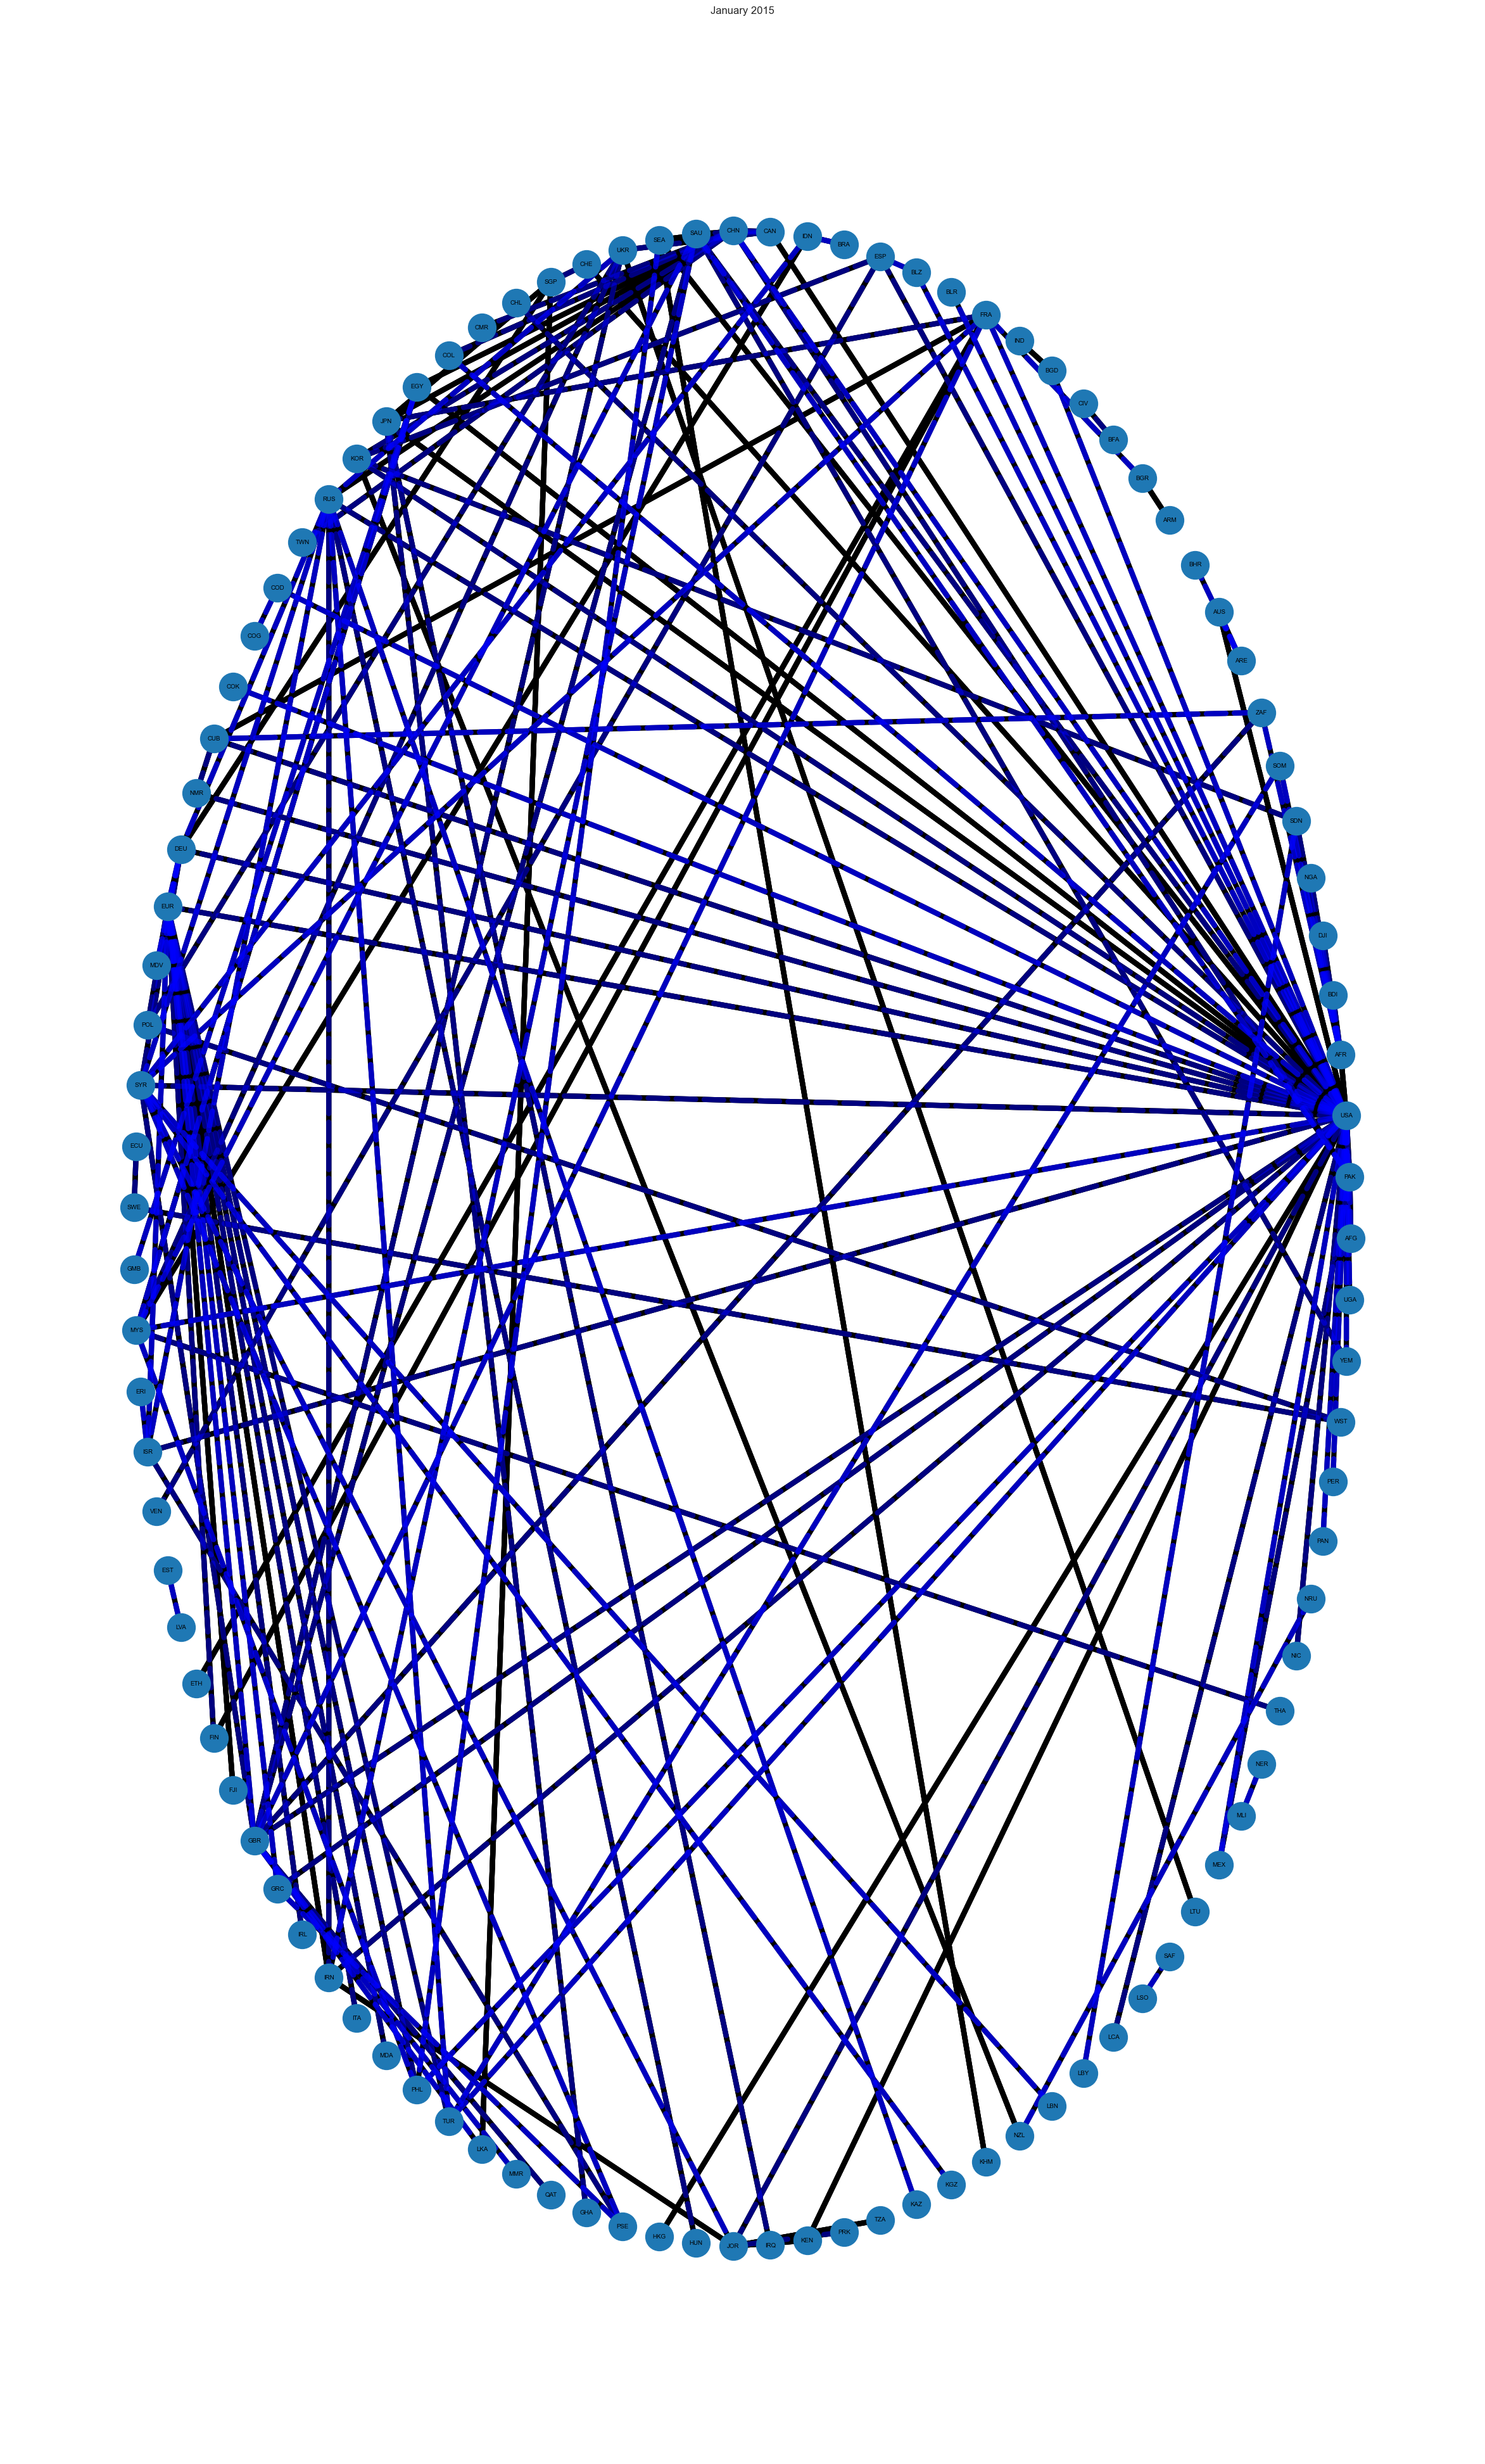

In [181]:
elarge=[(u,v) for (u,v,d) in g.edges if d >0.5]
esmall=[(u,v) for (u,v,d) in g.edges if d <=0.5]

plt.figure(figsize=(30, 50))
pos=nx.circular_layout(g) # positions for all nodes

# nodes
nx.draw_networkx_nodes(g,pos,node_size=1000)

# edges
nx.draw_networkx_edges(g,pos,edgelist=elarge,
                    width=6)
nx.draw_networkx_edges(g,pos,edgelist=esmall,
                    width=6,alpha=0.5,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(g,pos,font_size=7,font_family='sans-serif')

plt.axis('off')
plt.title('January 2015')
plt.savefig("weighted_graph.png") # save as png
plt.show() # display

### Building graph with attributes on edges

In [ ]:
g = nx.MultiGraph()

In [ ]:
for i in range(data.shape[0]):
    if data.iloc[i,0] == '2015-01-31':
        g.add_edge(data.iloc[i,1], data.iloc[i,2], glt_sc = data.iloc[i,3], avg_tone = data.iloc[i,4], num_mentions= data.iloc[i,5], num_articles= data.iloc[i,6])
    else:
        break 

In [ ]:
g.edges()

In [ ]:
for (u,v,d) in g.edges(data=True):
    print((u,v,d))